In [0]:
# !pip install albumentations
# !pip install scipy

# Imports

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import albumentations as amt
from scipy.ndimage import rotate, zoom

# Util functions

In [0]:
def show_all(image_list, title_list, inarow=5):
  plt.figure(figsize=[30,20])
  assert len(image_list) == len(title_list), "Houston we've got a problem"
  N = len(image_list)
  lines = int(N / inarow)+1
  for index, (img, title) in enumerate(zip(image_list, title_list)):
    plt.subplot(lines, inarow, index+1)
    if len(img.shape) != 3:
      plt.imshow(img)
    else:
      plt.imshow(img)
    plt.title(title)

In [0]:
def norm(img):
  img = img.astype(np.float32)
  img -= img.min()
  img /= img.max()
  return img

# Augmentation class

In [0]:
class Augmentation(object):
  def __init__(self):
    pass

  def flip_horizontal(self, img):
    horiz = amt.HorizontalFlip(p=1)
    return horiz(image=img)['image']

  def flip_vertical(self, img):
    vert = amt.VerticalFlip(p=1)
    return vert(image=img)['image']

  def rotate_by_degree(self, img, deg=None):
    if deg == None:
      deg = np.random.randint(0, high=360)
    rot = rotate(img, deg, reshape=False)
    return rot

  def gaussian_blur(self, img, k_size=None):
    if k_size == None:
      k_size = np.random.randint(3, high=9)
      if k_size % 2 == 0:
        k_size -= 1
    return cv2.GaussianBlur(img, (k_size, k_size), 0)

  def median_blur(self, img, k_size=None):
    if k_size == None:
      k_size = np.random.randint(3, high=9)
      if k_size % 2 == 0:
        k_size -= 1
    return cv2.medianBlur(img, k_size)

  def zoom(self, img, zoom_factor=None):
    if zoom_factor == None:
      zoom_factor = round(np.random.uniform(low=1.1, high=1.7), 2)

    height, width = img.shape[:2] 
    new_height, new_width = int(height * zoom_factor), int(width * zoom_factor)

    ### Crop only the part that will remain in the result (more efficient)
    # Centered bbox of the final desired size in resized (larger/smaller) image coordinates
    y1, x1 = max(0, new_height - height) // 2, max(0, new_width - width) // 2
    y2, x2 = y1 + height, x1 + width
    bbox = np.array([y1,x1,y2,x2])
    # Map back to original image coordinates
    bbox = (bbox / zoom_factor).astype(np.int)
    y1, x1, y2, x2 = bbox
    cropped_img = img[y1:y2, x1:x2]

    # Handle padding when downscaling
    resize_height, resize_width = min(new_height, height), min(new_width, width)
    pad_height1, pad_width1 = (height - resize_height) // 2, (width - resize_width) //2
    pad_height2, pad_width2 = (height - resize_height) - pad_height1, (width - resize_width) - pad_width1
    pad_spec = [(pad_height1, pad_height2), (pad_width1, pad_width2)] + [(0,0)] * (img.ndim - 2)

    result = cv2.resize(cropped_img, (resize_width, resize_height))
    result = np.pad(result, pad_spec, mode='constant')
    assert result.shape[0] == height and result.shape[1] == width
    return result
    
  def crop(self, img, start_x=None, end_x=None, start_y=None, end_y=None):
    img_shape = img.shape
    if start_x == None:
      start_x = np.random.randint(100, high=img_shape[1]/2-img_shape[1]/4)
    if end_x == None:
      end_x = np.random.randint(img_shape[1]/2+img_shape[1]/4, high=img_shape[1]-1)
    if start_y == None:
      start_y = np.random.randint(100, img_shape[0]/2-img_shape[0]/4)
    if end_y == None:
      end_y = np.random.randint(img_shape[0]/2+img_shape[0]/4, img_shape[0]-1)

    crop = amt.Crop(start_x, start_y, end_x, end_y)
    return crop(image=img)['image']

## Class inherit from Augmentation class to apply N augmentations with M chance

In [0]:
class AugmentWithProb(Augmentation):
  '''
    Augment an image with N random augmentations, each has M chance to actucaly impact.
  '''
  def __init__(self):
    self.augs = [self.flip_horizontal, self.flip_vertical, self.rotate_by_degree, self.gaussian_blur, self.median_blur, self.zoom, self.crop]

  def augment(self, image, N, M):
    aug_selected = np.random.choice(self.augs, N, replace=False)
    for i in range(len(aug_selected)):
      rand_chance = np.random.randint(0, high=100) / 100
      if M >= rand_chance:
        image = aug_selected[i](image)
    return image

  def create_augmented_images(self, img, N, M, num_of_images=50):
    images = []
    for i in range(num_of_images):
      images.append(self.augment(img, N, M))
    return images, [str(idx) for idx in range(1, num_of_images+1)]

# Original image

Text(0.5, 1.0, 'No augmentations')

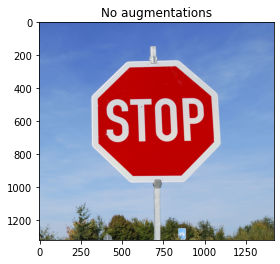

In [7]:
im = cv2.imread("./stopsign.jpg")
im_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(im_rgb)
plt.title('No augmentations')

# Applying N augmentations with M chance for each augmentation to impact on the image, where **N=5, M=0.5**

any N and M can be inserted. N is integer between 0-6, M is float between 0-1 (any M below or equal to 0 will cause no augment to impact, any M above or equal to 1 will cause all augmentation selected to impact.) 

Augmentations are selected randomly from the available augmentations of the Augmentation() class

In [0]:
aug_p = AugmentWithProb()
show_images, show_lbls = aug_p.create_augmented_images(im_rgb, 5, 0.5)

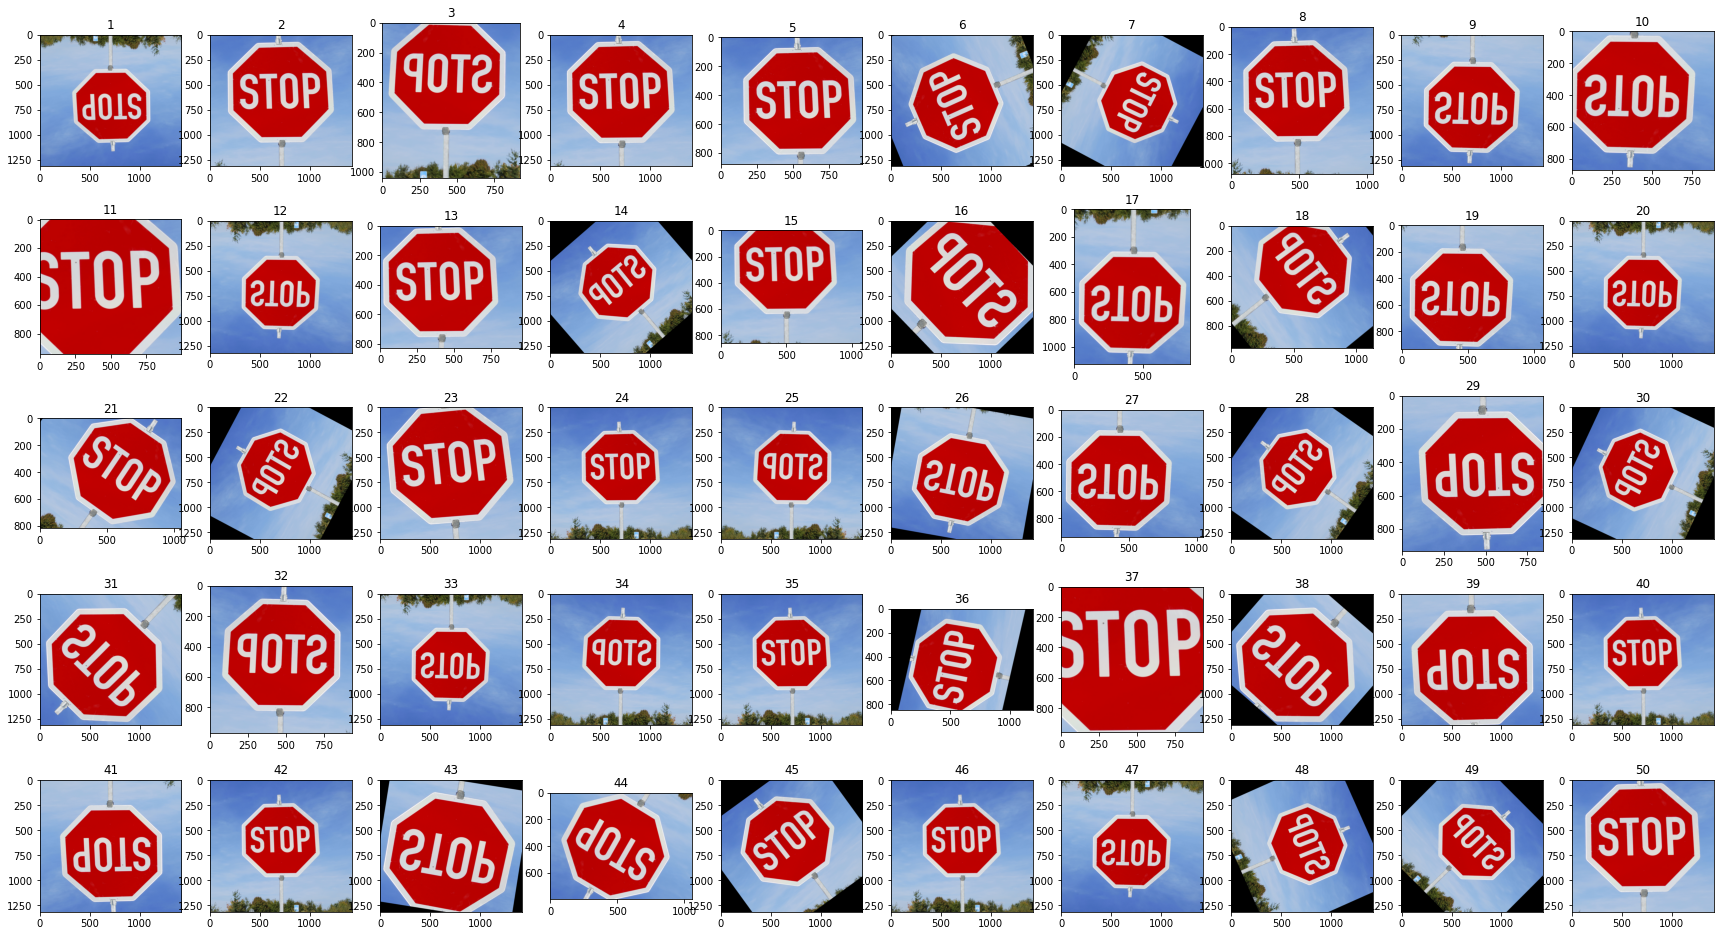

In [9]:
show_all(show_images, show_lbls, 10)